# Spaceship Titanic - V6 (Optuna Hyperparameter Optimization)

**Base:** V2 features (29 features, best LB 0.80710)  
**Goal:** Optuna 200 trials per model on LightGBM, XGBoost, CatBoost  
**Strategy:**
- 5-fold CV for Optuna (speed)
- 10-fold CV for final training (stability)
- Early stopping in each trial
- Simple average ensemble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
import warnings, os, time

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

SEED = 42
N_FOLDS_OPTUNA = 5   # faster for optimization
N_FOLDS_FINAL = 10   # stable for final training
N_TRIALS = 200
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()
print(f'V6 Setup: {N_TRIALS} trials per model, {N_FOLDS_OPTUNA}-fold optuna, {N_FOLDS_FINAL}-fold final')

V6 Setup: 200 trials per model, 5-fold optuna, 10-fold final


C:\Users\Amaury\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(f'Combined: {df.shape}')

Combined: (12970, 15)


## V2 Feature Engineering (identical)

In [3]:
# === V2 FE (copy-paste from V2) ===
df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
df['Side'] = df['Cabin'].str.split('/').str[2]
df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)

df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
df.loc[df['Surname'].isna(), 'FamilySize'] = 1

df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})

# Imputation
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0

mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) == 0)
df.loc[mask, 'CryoSleep'] = 1
mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) > 0)
df.loc[mask, 'CryoSleep'] = 0

for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Spending
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)
for col in spend_cols:
    df[f'{col}_log'] = np.log1p(df[col])
df['LuxurySpend'] = np.log1p(df['Spa'] + df['VRDeck'] + df['RoomService'])
df['BasicSpend'] = np.log1p(df['FoodCourt'] + df['ShoppingMall'])

# Age
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 30, 50, 80], labels=[0,1,2,3,4,5]).astype(float)
df['IsChild'] = (df['Age'] < 18).astype(float)

# Interactions
df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)

# Group spending
df['GroupSpend_mean'] = df.groupby('_Group')['TotalSpend'].transform('mean')
df['GroupSpend_mean_log'] = np.log1p(df['GroupSpend_mean'])

# Encodings
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

print('V2 FE done.')

V2 FE done.


In [4]:
# V2 features (identical)
drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side',
    '_Group', 'CabinNum',
    'TotalSpend', 'GroupSpend_mean',
] + spend_cols

features = [c for c in df.columns if c not in drop_cols]
print(f'V2 features: {len(features)}')

train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].astype(int).values
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')

V2 features: 29
X: (8693, 29), y: (8693,), X_test: (4277, 29)


## Optuna: LightGBM (200 trials)

In [5]:
def lgb_objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 8, 64),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'n_estimators': 5000,
        'verbose': -1,
        'n_jobs': -1,
        'random_state': SEED,
    }
    
    kf = StratifiedKFold(n_splits=N_FOLDS_OPTUNA, shuffle=True, random_state=SEED)
    scores = []
    
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        preds = model.predict_proba(X_val)[:, 1]
        acc = accuracy_score(y_val, (preds > 0.5).astype(int))
        scores.append(acc)
    
    return np.mean(scores)

print(f'Starting LightGBM Optuna: {N_TRIALS} trials...')
t0 = time.time()

lgb_study = optuna.create_study(direction='maximize', study_name='lgb')
lgb_study.optimize(lgb_objective, n_trials=N_TRIALS, show_progress_bar=False)

print(f'\nLightGBM Optuna done in {time.time()-t0:.0f}s')
print(f'Best CV Accuracy: {lgb_study.best_value:.5f}')
print(f'Best params:')
for k, v in lgb_study.best_params.items():
    print(f'  {k}: {v}')

Starting LightGBM Optuna: 200 trials...
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.383232
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.391509
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.380468
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.375363
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[335]	valid_0's binary_logloss: 0.404597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.383012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.390616


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.379923
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.373688
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.405485
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[636]	valid_0's binary_logloss: 0.382269
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[613]	valid_0's binary_logloss: 0.393544
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[906]	valid_0's binary_logloss: 0.378286
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[698]	valid_0's binary_logloss: 0.374535
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[710]	valid_0's binary_logloss: 0.399701
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[699]	valid_0's binary_logloss: 0.383733
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[549]	valid_0's binary_logloss: 0.391989
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[759]	valid_0's binary_logloss: 0.378893
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[565]	valid_0's binary_logloss: 0.377702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[463]	valid_0's binary_logloss: 0.403712


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[779]	valid_0's binary_logloss: 0.390468
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[680]	valid_0's binary_logloss: 0.399725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[762]	valid_0's binary_logloss: 0.387641


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[840]	valid_0's binary_logloss: 0.383203


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[979]	valid_0's binary_logloss: 0.406717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.37616
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.385901
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.372424
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.368617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.395212
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[293]	valid_0's binary_logloss: 0.377285
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.390298
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.379812
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.372985
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.400833
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[975]	valid_0's binary_logloss: 0.380567
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.396606
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[556]	valid_0's binary_logloss: 0.381902
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[839]	valid_0's binary_logloss: 0.374555
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[606]	valid_0's binary_logloss: 0.403043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[609]	valid_0's binary_logloss: 0.392446
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[819]	valid_0's binary_logloss: 0.400414
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[765]	valid_0's binary_logloss: 0.39064
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[425]	valid_0's binary_logloss: 0.387234
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[660]	valid_0's binary_logloss: 0.414396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[512]	valid_0's binary_logloss: 0.383644
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[540]	valid_0's binary_logloss: 0.393212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.382357
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.375326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.401738
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.381281
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.395016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.384684
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.390224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.411436
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[623]	valid_0's binary_logloss: 0.37653
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[984]	valid_0's binary_logloss: 0.38599
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[906]	valid_0's binary_logloss: 0.374717
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[727]	valid_0's binary_logloss: 0.371253
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[720]	valid_0's binary_logloss: 0.396317
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.371125
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.383358
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.378723
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.370895
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.397388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.379879
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.39272
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.379512
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.38066
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.403579
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.381657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.391973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.382377


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.37646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.404435
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.371288
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.383402


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.372404


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.369474
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.393223
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.379264
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.395028
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[495]	valid_0's binary_logloss: 0.376923
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[440]	valid_0's binary_logloss: 0.368629
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.401924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[217]	valid_0's binary_logloss: 0.380049
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.387622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	valid_0's binary_logloss: 0.379148
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.372706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.399027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.378725


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.386269
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.377345
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.371368
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.397651
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.380904
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[517]	valid_0's binary_logloss: 0.387185
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[402]	valid_0's binary_logloss: 0.378824
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[363]	valid_0's binary_logloss: 0.371598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.403094


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[856]	valid_0's binary_logloss: 0.391925
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[808]	valid_0's binary_logloss: 0.405944
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[999]	valid_0's binary_logloss: 0.393093
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[1225]	valid_0's binary_logloss: 0.390121
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[789]	valid_0's binary_logloss: 0.411429
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[613]	valid_0's binary_logloss: 0.376283
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[983]	valid_0's binary_logloss: 0.386302
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[967]	valid_0's binary_logloss: 0.37321
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[789]	valid_0's binary_logloss: 0.370694
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[774]	valid_0's binary_logloss: 0.396112
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.37674
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[604]	valid_0's binary_logloss: 0.387937
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[641]	valid_0's binary_logloss: 0.373459
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[571]	valid_0's binary_logloss: 0.369768
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[598]	valid_0's binary_logloss: 0.395877
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.376015
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[674]	valid_0's binary_logloss: 0.38625
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[642]	valid_0's binary_logloss: 0.372685
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[420]	valid_0's binary_logloss: 0.370126
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[486]	valid_0's binary_logloss: 0.396304
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[641]	valid_0's binary_logloss: 0.375496
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[637]	valid_0's binary_logloss: 0.385312
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[708]	valid_0's binary_logloss: 0.371053
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[673]	valid_0's binary_logloss: 0.370102
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[582]	valid_0's binary_logloss: 0.396587
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[590]	valid_0's binary_logloss: 0.375185
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[637]	valid_0's binary_logloss: 0.386262
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[715]	valid_0's binary_logloss: 0.371846
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[482]	valid_0's binary_logloss: 0.37131
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[473]	valid_0's binary_logloss: 0.395378
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[293]	valid_0's binary_logloss: 0.377484
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.388294
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[373]	valid_0's binary_logloss: 0.37852
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.37121
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.39701
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[536]	valid_0's binary_logloss: 0.376566
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[645]	valid_0's binary_logloss: 0.386961
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[599]	valid_0's binary_logloss: 0.375878
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[522]	valid_0's binary_logloss: 0.370982
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[488]	valid_0's binary_logloss: 0.396704
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[763]	valid_0's binary_logloss: 0.379427
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[879]	valid_0's binary_logloss: 0.389523
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[966]	valid_0's binary_logloss: 0.377726
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[672]	valid_0's binary_logloss: 0.373434
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[919]	valid_0's binary_logloss: 0.397683
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[571]	valid_0's binary_logloss: 0.375549
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[755]	valid_0's binary_logloss: 0.386197
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[839]	valid_0's binary_logloss: 0.375292
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[664]	valid_0's binary_logloss: 0.371205
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[610]	valid_0's binary_logloss: 0.397022
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.376986
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 0.389841
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[463]	valid_0's binary_logloss: 0.37523
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[583]	valid_0's binary_logloss: 0.369797
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.396489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.378114
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.387778
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.377464
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.36943
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.398269
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.375051
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.383894
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.375204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.369388
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.39745
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.375401
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.388379
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.373446
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.369954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.395514


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[472]	valid_0's binary_logloss: 0.380146
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[774]	valid_0's binary_logloss: 0.387213
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[665]	valid_0's binary_logloss: 0.375904
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[544]	valid_0's binary_logloss: 0.370472
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[575]	valid_0's binary_logloss: 0.399807
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[632]	valid_0's binary_logloss: 0.375699
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[855]	valid_0's binary_logloss: 0.388384
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[801]	valid_0's binary_logloss: 0.374749
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[612]	valid_0's binary_logloss: 0.371381
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[693]	valid_0's binary_logloss: 0.39545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.381751
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.392682
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.380215
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.371399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.40278
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[667]	valid_0's binary_logloss: 0.383788
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[1068]	valid_0's binary_logloss: 0.390719
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[1077]	valid_0's binary_logloss: 0.379313
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[902]	valid_0's binary_logloss: 0.375549
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[1029]	valid_0's binary_logloss: 0.399867
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.374634
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[456]	valid_0's binary_logloss: 0.388064
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[486]	valid_0's binary_logloss: 0.373559
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.369921
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.393909
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.37097
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.385362
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.373814
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.374234
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.39744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.3834
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[292]	valid_0's binary_logloss: 0.396462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.380337
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.37464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.408053
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[610]	valid_0's binary_logloss: 0.375226
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[623]	valid_0's binary_logloss: 0.387514
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[725]	valid_0's binary_logloss: 0.372469
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[652]	valid_0's binary_logloss: 0.369917
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[492]	valid_0's binary_logloss: 0.39655
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[493]	valid_0's binary_logloss: 0.377924
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[872]	valid_0's binary_logloss: 0.388116
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[598]	valid_0's binary_logloss: 0.376667
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[597]	valid_0's binary_logloss: 0.372052
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[556]	valid_0's binary_logloss: 0.401231
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[512]	valid_0's binary_logloss: 0.370507
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[503]	valid_0's binary_logloss: 0.386134
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[533]	valid_0's binary_logloss: 0.371676
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[475]	valid_0's binary_logloss: 0.368429
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[439]	valid_0's binary_logloss: 0.393573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.372257
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.388588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.372899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.369618
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.392233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.372456
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.386243
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.373131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.368339
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.393479
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.375515
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 0.387823
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.375055
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.369429
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.399037


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.376683


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.387586
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 0.375512
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[292]	valid_0's binary_logloss: 0.369779
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.398903


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.374262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.381718
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.375366
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.37297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.396829
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[280]	valid_0's binary_logloss: 0.372327
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.385093
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[358]	valid_0's binary_logloss: 0.373525
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[251]	valid_0's binary_logloss: 0.367833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.392913
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[313]	valid_0's binary_logloss: 0.376513
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[552]	valid_0's binary_logloss: 0.38512
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[530]	valid_0's binary_logloss: 0.371028
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[564]	valid_0's binary_logloss: 0.36808
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[542]	valid_0's binary_logloss: 0.392923
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[452]	valid_0's binary_logloss: 0.380282
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[536]	valid_0's binary_logloss: 0.392354
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[527]	valid_0's binary_logloss: 0.377886
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[534]	valid_0's binary_logloss: 0.371947
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[453]	valid_0's binary_logloss: 0.402649
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[380]	valid_0's binary_logloss: 0.377009
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[342]	valid_0's binary_logloss: 0.386915
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.376536
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 0.373126
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.401308
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[298]	valid_0's binary_logloss: 0.380097
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.38777
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[389]	valid_0's binary_logloss: 0.377078
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.372532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.400258


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[605]	valid_0's binary_logloss: 0.374857
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[637]	valid_0's binary_logloss: 0.389423
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[541]	valid_0's binary_logloss: 0.376841
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[496]	valid_0's binary_logloss: 0.372249
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[550]	valid_0's binary_logloss: 0.398092
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.380307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.392435
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.378403
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.370611
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.404961
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[422]	valid_0's binary_logloss: 0.373833
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[377]	valid_0's binary_logloss: 0.387332
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[527]	valid_0's binary_logloss: 0.375103
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.373349
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.39476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.382252
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.391697
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.379869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.374131


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.406052
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[649]	valid_0's binary_logloss: 0.383733
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[879]	valid_0's binary_logloss: 0.392522
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[774]	valid_0's binary_logloss: 0.378638
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[952]	valid_0's binary_logloss: 0.372613
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[678]	valid_0's binary_logloss: 0.400725
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.377542
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[402]	valid_0's binary_logloss: 0.387105
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.376095
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[421]	valid_0's binary_logloss: 0.370314
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.40038
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.377046
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[615]	valid_0's binary_logloss: 0.39119
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[597]	valid_0's binary_logloss: 0.377763
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[475]	valid_0's binary_logloss: 0.374659
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.403016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.373987
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.385402
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.375323
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.371242
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.395793
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.384128
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.39204
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.382693
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.379414
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.403286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.378368
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.386941
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 0.376918


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.372007
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.398426
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.375408
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.387794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[251]	valid_0's binary_logloss: 0.374915
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.370903
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[251]	valid_0's binary_logloss: 0.396905
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.379603
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.391686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.383714
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.374081
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.400864
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.373246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.386348
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.377826
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.369206
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.398413
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.373978
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.383936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.377061
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.369617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.397894
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 0.374362
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.387727
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[604]	valid_0's binary_logloss: 0.373932
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.367373
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.397273
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.371215
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.387122
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.373229
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.372137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.403311
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.378725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.390174
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.380746
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.371964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.395283
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.37546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.39072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.372345


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.372101
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.395827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's binary_logloss: 0.374834
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.387624
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.375536
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.372382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.399466
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[450]	valid_0's binary_logloss: 0.376918
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.388349
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[488]	valid_0's binary_logloss: 0.373877
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.369932
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[403]	valid_0's binary_logloss: 0.397632
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[508]	valid_0's binary_logloss: 0.379804
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[684]	valid_0's binary_logloss: 0.388135
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[572]	valid_0's binary_logloss: 0.375688
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[656]	valid_0's binary_logloss: 0.370162
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[549]	valid_0's binary_logloss: 0.396587
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.375155
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[314]	valid_0's binary_logloss: 0.389204
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.377228
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.370149
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[259]	valid_0's binary_logloss: 0.401289
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[341]	valid_0's binary_logloss: 0.37735
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.388737
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.375666
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[287]	valid_0's binary_logloss: 0.371946


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.40109
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[272]	valid_0's binary_logloss: 0.376546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	valid_0's binary_logloss: 0.390289


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 0.374391


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[292]	valid_0's binary_logloss: 0.369815
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.399789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.379088
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.389471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.374207
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.3702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.39833
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.377494
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[342]	valid_0's binary_logloss: 0.388306
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.376024
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.368726
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.402473


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.373133
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.388708
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.372985


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.371779
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.400426
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 0.37868
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 0.389834
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.375498


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid_0's binary_logloss: 0.369813
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.39732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.379748
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.392917
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.377108
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.372542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.399713
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.376186
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 0.386475
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[624]	valid_0's binary_logloss: 0.374696
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[435]	valid_0's binary_logloss: 0.366505
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[365]	valid_0's binary_logloss: 0.399919
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[545]	valid_0's binary_logloss: 0.378312
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[768]	valid_0's binary_logloss: 0.388692
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[718]	valid_0's binary_logloss: 0.375668
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[642]	valid_0's binary_logloss: 0.371306
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[483]	valid_0's binary_logloss: 0.401109
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.377139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.385147
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.376422
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.372633
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.396498
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[523]	valid_0's binary_logloss: 0.375658
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[508]	valid_0's binary_logloss: 0.38831
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.372888
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[582]	valid_0's binary_logloss: 0.370195
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[480]	valid_0's binary_logloss: 0.396383
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.378304
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 0.388572
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[433]	valid_0's binary_logloss: 0.375729
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[411]	valid_0's binary_logloss: 0.372096
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.398678
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[424]	valid_0's binary_logloss: 0.377351
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[406]	valid_0's binary_logloss: 0.389249
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[531]	valid_0's binary_logloss: 0.376419
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[476]	valid_0's binary_logloss: 0.370265
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.398573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.374224
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.389049
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.374026
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.370643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.399718
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.381715
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.390128
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.37856
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.375266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.403532
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.378994
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.393257
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.377665
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[346]	valid_0's binary_logloss: 0.37153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.401333
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.37805
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.389036
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.378053
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.371785
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[292]	valid_0's binary_logloss: 0.401049
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[428]	valid_0's binary_logloss: 0.376769
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[330]	valid_0's binary_logloss: 0.391983
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.377489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.373059
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.402293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.381358
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[411]	valid_0's binary_logloss: 0.393127
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.37958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.37724
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.404249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.378552
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.38696
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[326]	valid_0's binary_logloss: 0.374183
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.36876
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.398796
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[280]	valid_0's binary_logloss: 0.37343
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[391]	valid_0's binary_logloss: 0.387967
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.375992
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[339]	valid_0's binary_logloss: 0.368892
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[343]	valid_0's binary_logloss: 0.394926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.373649


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.384445
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[259]	valid_0's binary_logloss: 0.372253
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.373327
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.396489
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[452]	valid_0's binary_logloss: 0.375338
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[342]	valid_0's binary_logloss: 0.389222
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[548]	valid_0's binary_logloss: 0.372806
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[605]	valid_0's binary_logloss: 0.368213
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.395899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.375879
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.388071
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.378765
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.373341
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.402851
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.375724
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[376]	valid_0's binary_logloss: 0.386047
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[426]	valid_0's binary_logloss: 0.372553
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[284]	valid_0's binary_logloss: 0.370374
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[277]	valid_0's binary_logloss: 0.394704
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.374569
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[373]	valid_0's binary_logloss: 0.385741
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.374419
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.368933
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[292]	valid_0's binary_logloss: 0.394452
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.374497
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[376]	valid_0's binary_logloss: 0.38748
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.375324
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[420]	valid_0's binary_logloss: 0.369453
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 0.39515
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.372069
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[266]	valid_0's binary_logloss: 0.384851
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[221]	valid_0's binary_logloss: 0.373815
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.373176
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.396852
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[520]	valid_0's binary_logloss: 0.376771
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[816]	valid_0's binary_logloss: 0.387407
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[835]	valid_0's binary_logloss: 0.375595
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[597]	valid_0's binary_logloss: 0.373535
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[611]	valid_0's binary_logloss: 0.398791
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.372866
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.385398
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[453]	valid_0's binary_logloss: 0.371934
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.36992
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.39379
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.376062
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[435]	valid_0's binary_logloss: 0.387033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.37539
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.37253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.40023
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[613]	valid_0's binary_logloss: 0.37265
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[794]	valid_0's binary_logloss: 0.384162
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[755]	valid_0's binary_logloss: 0.370524
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[521]	valid_0's binary_logloss: 0.370947
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[598]	valid_0's binary_logloss: 0.393982
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[571]	valid_0's binary_logloss: 0.373121
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[550]	valid_0's binary_logloss: 0.388163
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[635]	valid_0's binary_logloss: 0.372453
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[567]	valid_0's binary_logloss: 0.369128
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 0.395008
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[623]	valid_0's binary_logloss: 0.374289
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[715]	valid_0's binary_logloss: 0.385994
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[909]	valid_0's binary_logloss: 0.374113
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[775]	valid_0's binary_logloss: 0.369424
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[660]	valid_0's binary_logloss: 0.395219
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[549]	valid_0's binary_logloss: 0.373371
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[790]	valid_0's binary_logloss: 0.38565
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[636]	valid_0's binary_logloss: 0.37055
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[600]	valid_0's binary_logloss: 0.370875
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[517]	valid_0's binary_logloss: 0.393841
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[585]	valid_0's binary_logloss: 0.372807
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[707]	valid_0's binary_logloss: 0.385236
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[699]	valid_0's binary_logloss: 0.370066
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[520]	valid_0's binary_logloss: 0.371653
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[439]	valid_0's binary_logloss: 0.395878
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.372951
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[727]	valid_0's binary_logloss: 0.385089
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[669]	valid_0's binary_logloss: 0.371907
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[604]	valid_0's binary_logloss: 0.370031
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[580]	valid_0's binary_logloss: 0.394468
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[745]	valid_0's binary_logloss: 0.372421
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[837]	valid_0's binary_logloss: 0.385494
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[837]	valid_0's binary_logloss: 0.370233
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[604]	valid_0's binary_logloss: 0.370907
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[517]	valid_0's binary_logloss: 0.395182
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[477]	valid_0's binary_logloss: 0.374779
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[659]	valid_0's binary_logloss: 0.3868
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[774]	valid_0's binary_logloss: 0.371832
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[584]	valid_0's binary_logloss: 0.37099
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[432]	valid_0's binary_logloss: 0.395763
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[1139]	valid_0's binary_logloss: 0.383724
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[1334]	valid_0's binary_logloss: 0.393548
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[1173]	valid_0's binary_logloss: 0.384419
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[953]	valid_0's binary_logloss: 0.379183
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[940]	valid_0's binary_logloss: 0.400513
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[391]	valid_0's binary_logloss: 0.371554
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.384564
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[404]	valid_0's binary_logloss: 0.371651
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.370191
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.392629
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.382092
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[513]	valid_0's binary_logloss: 0.392482
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[405]	valid_0's binary_logloss: 0.381032
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[387]	valid_0's binary_logloss: 0.375985
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[451]	valid_0's binary_logloss: 0.402503
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.375392
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.387171
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[532]	valid_0's binary_logloss: 0.371122
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[424]	valid_0's binary_logloss: 0.370179
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.395974
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[493]	valid_0's binary_logloss: 0.372124
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[629]	valid_0's binary_logloss: 0.38485
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[611]	valid_0's binary_logloss: 0.370533
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.372154
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.395784
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[445]	valid_0's binary_logloss: 0.372531
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[557]	valid_0's binary_logloss: 0.384221
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[594]	valid_0's binary_logloss: 0.372312
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[403]	valid_0's binary_logloss: 0.368545
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[432]	valid_0's binary_logloss: 0.393269
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[486]	valid_0's binary_logloss: 0.374436
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[600]	valid_0's binary_logloss: 0.388586
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[476]	valid_0's binary_logloss: 0.37577
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[440]	valid_0's binary_logloss: 0.371961
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.39864
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[533]	valid_0's binary_logloss: 0.373252
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[609]	valid_0's binary_logloss: 0.385069
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[624]	valid_0's binary_logloss: 0.373116
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[565]	valid_0's binary_logloss: 0.369319
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[513]	valid_0's binary_logloss: 0.393854
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[519]	valid_0's binary_logloss: 0.37274
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[757]	valid_0's binary_logloss: 0.385973
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[648]	valid_0's binary_logloss: 0.370333
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[525]	valid_0's binary_logloss: 0.370183
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.395918
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[466]	valid_0's binary_logloss: 0.37166
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[479]	valid_0's binary_logloss: 0.385862
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[564]	valid_0's binary_logloss: 0.372434
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.370449
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[490]	valid_0's binary_logloss: 0.391715
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[402]	valid_0's binary_logloss: 0.373012
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.388197
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[588]	valid_0's binary_logloss: 0.372088
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[342]	valid_0's binary_logloss: 0.368613
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.394262
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.371011
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.387111
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.372762
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.368036
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.392524
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[676]	valid_0's binary_logloss: 0.371581
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[783]	valid_0's binary_logloss: 0.385291
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[577]	valid_0's binary_logloss: 0.374871
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[569]	valid_0's binary_logloss: 0.374641
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[544]	valid_0's binary_logloss: 0.393806
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[414]	valid_0's binary_logloss: 0.376527
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[675]	valid_0's binary_logloss: 0.386721
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[645]	valid_0's binary_logloss: 0.373156
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[529]	valid_0's binary_logloss: 0.370416
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[428]	valid_0's binary_logloss: 0.39629
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[557]	valid_0's binary_logloss: 0.378098
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[860]	valid_0's binary_logloss: 0.387935
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[710]	valid_0's binary_logloss: 0.374498
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[672]	valid_0's binary_logloss: 0.368754
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[492]	valid_0's binary_logloss: 0.398868
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.37995
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.390363
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[568]	valid_0's binary_logloss: 0.3755
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[421]	valid_0's binary_logloss: 0.370879
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.397946
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[578]	valid_0's binary_logloss: 0.374819
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[671]	valid_0's binary_logloss: 0.386264
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[642]	valid_0's binary_logloss: 0.373113
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[573]	valid_0's binary_logloss: 0.370022
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[480]	valid_0's binary_logloss: 0.396964
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[513]	valid_0's binary_logloss: 0.373173
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[751]	valid_0's binary_logloss: 0.385827
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[645]	valid_0's binary_logloss: 0.373128
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[572]	valid_0's binary_logloss: 0.370553
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[602]	valid_0's binary_logloss: 0.395998
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[563]	valid_0's binary_logloss: 0.372509
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[914]	valid_0's binary_logloss: 0.383157
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[825]	valid_0's binary_logloss: 0.370552
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[585]	valid_0's binary_logloss: 0.371977
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[606]	valid_0's binary_logloss: 0.393382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.376944
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.386097
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.374341
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.371591


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.395871
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.370916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.384964
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.374104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.369787
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.394652
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[471]	valid_0's binary_logloss: 0.373095
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[538]	valid_0's binary_logloss: 0.386494
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[572]	valid_0's binary_logloss: 0.37317
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[460]	valid_0's binary_logloss: 0.371496
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[492]	valid_0's binary_logloss: 0.395467
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.371451
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.386594
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[283]	valid_0's binary_logloss: 0.372336
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.370498
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.39637
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[921]	valid_0's binary_logloss: 0.385397
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[813]	valid_0's binary_logloss: 0.394735
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[732]	valid_0's binary_logloss: 0.384415
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[749]	valid_0's binary_logloss: 0.376374
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[729]	valid_0's binary_logloss: 0.406392
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.372277
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.385316
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[533]	valid_0's binary_logloss: 0.371678
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.370836
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.395448
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.377
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.386605
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.379264
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.370263
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.396069
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[546]	valid_0's binary_logloss: 0.373221
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[792]	valid_0's binary_logloss: 0.384147
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[630]	valid_0's binary_logloss: 0.371364
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.371708
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[511]	valid_0's binary_logloss: 0.394597
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[516]	valid_0's binary_logloss: 0.372462
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[585]	valid_0's binary_logloss: 0.385285
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[637]	valid_0's binary_logloss: 0.371108
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[520]	valid_0's binary_logloss: 0.369186
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[551]	valid_0's binary_logloss: 0.394249
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[555]	valid_0's binary_logloss: 0.371661
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[558]	valid_0's binary_logloss: 0.386029
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.371098
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[413]	valid_0's binary_logloss: 0.372386
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[517]	valid_0's binary_logloss: 0.393991
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[496]	valid_0's binary_logloss: 0.378692
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[701]	valid_0's binary_logloss: 0.388678
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[606]	valid_0's binary_logloss: 0.37563
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[589]	valid_0's binary_logloss: 0.372605
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[690]	valid_0's binary_logloss: 0.399261
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.382702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.392026
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.377829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.373883
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.401222
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.374155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.384464
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.372906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.371115
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.39453
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 0.372051
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.383616
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[397]	valid_0's binary_logloss: 0.370492
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.369733
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 0.393653
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[476]	valid_0's binary_logloss: 0.372765
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[547]	valid_0's binary_logloss: 0.384785
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.372676
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[343]	valid_0's binary_logloss: 0.37107
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[393]	valid_0's binary_logloss: 0.393711
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[477]	valid_0's binary_logloss: 0.373084
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[543]	valid_0's binary_logloss: 0.383865
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[562]	valid_0's binary_logloss: 0.372846
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.370913
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[391]	valid_0's binary_logloss: 0.396631
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.37376
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.384825
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.373255
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.371347
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.396277
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.37375
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.385149
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[335]	valid_0's binary_logloss: 0.372189
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.36992
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.396046
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[367]	valid_0's binary_logloss: 0.373933
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[407]	valid_0's binary_logloss: 0.384183
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.373186
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[389]	valid_0's binary_logloss: 0.369561
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.397122
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.37016
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.384982
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[351]	valid_0's binary_logloss: 0.372788
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.371411
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.395936
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[277]	valid_0's binary_logloss: 0.372845
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[293]	valid_0's binary_logloss: 0.385585
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.370615
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.368918
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.396221
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[217]	valid_0's binary_logloss: 0.373976
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.383612
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.370825
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.370466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.395556


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.371925
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.385527
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 0.371888
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.372763
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.39592
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.372565
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[444]	valid_0's binary_logloss: 0.384878
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[358]	valid_0's binary_logloss: 0.372851
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.370091
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.396408
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.371152
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.384381
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.372783
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.371289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.39554
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.370883
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[351]	valid_0's binary_logloss: 0.386253
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.370627
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.369639
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.394032
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.372483
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.385593
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.369833
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.37064
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.394672
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.372166
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[369]	valid_0's binary_logloss: 0.386038
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[380]	valid_0's binary_logloss: 0.373389
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.368691
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.394568
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.372148
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[406]	valid_0's binary_logloss: 0.383888
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[381]	valid_0's binary_logloss: 0.371783
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.370552
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.395702
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.371908
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.385384
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.371616
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.371963
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.39535
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.372306
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.386
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.370878
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.369868
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.395247
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.373109
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.382952
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[298]	valid_0's binary_logloss: 0.373805
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.370574
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[272]	valid_0's binary_logloss: 0.394862
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.371472
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.384839
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.373281
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.368983
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.394675
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[369]	valid_0's binary_logloss: 0.372258
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.384969
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[287]	valid_0's binary_logloss: 0.374551
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.367481
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.395467
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.37287
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.384607
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.372889
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[283]	valid_0's binary_logloss: 0.367936
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.395813
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.371467
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.385216
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.373956
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[283]	valid_0's binary_logloss: 0.369255
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.394916
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.370396
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.384272
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.372549
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.369178
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.394851
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[303]	valid_0's binary_logloss: 0.372262
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.383312
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.372965
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.369043
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.396755
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.371971
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.383549
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.372749
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[266]	valid_0's binary_logloss: 0.369055
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.393939
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.370572
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[358]	valid_0's binary_logloss: 0.382795
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.372956
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[287]	valid_0's binary_logloss: 0.369574
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.395317
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.37193
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[381]	valid_0's binary_logloss: 0.384394
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.373747
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.369875
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.394712
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.37251
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[405]	valid_0's binary_logloss: 0.383395
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 0.371301
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.36792
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.394764
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.371722
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.383973
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[398]	valid_0's binary_logloss: 0.371875
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.368881
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.394746
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.371446
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[393]	valid_0's binary_logloss: 0.383479
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[471]	valid_0's binary_logloss: 0.371841
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[302]	valid_0's binary_logloss: 0.369091
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.395874
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.373205
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.384564
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.372048
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.370329
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.395872
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.371476
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[371]	valid_0's binary_logloss: 0.384373
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[398]	valid_0's binary_logloss: 0.372244
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[276]	valid_0's binary_logloss: 0.368718
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.393901
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.372139
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.38427
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.372523
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[283]	valid_0's binary_logloss: 0.3683
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.395126
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.37216
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[370]	valid_0's binary_logloss: 0.384795
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[454]	valid_0's binary_logloss: 0.372275
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.369879
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.393591
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.372617
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[399]	valid_0's binary_logloss: 0.384233
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[453]	valid_0's binary_logloss: 0.372435
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.369259
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.394907
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.372362
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[405]	valid_0's binary_logloss: 0.385138
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[454]	valid_0's binary_logloss: 0.372947
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.36911
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.394672
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.372466
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.384703
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.373118
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.365846
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.394403
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.373999
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.386373
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.372343
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.368961
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.394674
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.371993
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.385111
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[384]	valid_0's binary_logloss: 0.371416
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.369353
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.394431
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.372072
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.385192
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.371601
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[287]	valid_0's binary_logloss: 0.367318
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.395587
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.372604
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.383528
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.373332
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.367583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.397092


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.373236
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.384475
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.372855
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.367733
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.394949
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.373028


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.385106
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[273]	valid_0's binary_logloss: 0.370246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.36933


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.395183
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.373586
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.385108
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.372036
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.367323
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.396408
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[299]	valid_0's binary_logloss: 0.372116
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[381]	valid_0's binary_logloss: 0.383409
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.374147
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.367754
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.396772
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.372905
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.384792
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.372669
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.367471
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.397942
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.373519
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[405]	valid_0's binary_logloss: 0.383597
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.374186
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.369836
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.397042
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.37293
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.384337
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.373827
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.367518
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.395787
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.370953
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.386286
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.369863
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.368597
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.394206
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.37262
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.385318
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.37363
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.370674
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.396088


Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.372373
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.382965
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[387]	valid_0's binary_logloss: 0.372774
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[287]	valid_0's binary_logloss: 0.369338
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.394006
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[462]	valid_0's binary_logloss: 0.37331
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.384378
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.372953
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.368984
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[363]	valid_0's binary_logloss: 0.393087

LightGBM Optuna done in 288s
Best CV Accuracy: 0.81583
Best params:
  num_leaves: 44
  max_depth: 7
  learning_rate: 0.030969372942932262
  feature_fraction: 0.6576757841672172
  bagging_fraction: 0.835862275982545
  bagging_freq: 3
  min_child_samples: 48
  reg_alpha: 1.196564578792742
  reg_lambda: 0.46422611416669396
  min_split_gain: 0.1325484921651904


## Optuna: XGBoost (200 trials)

In [6]:
def xgb_objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.95),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),
        'n_estimators': 5000,
        'early_stopping_rounds': 50,
        'tree_method': 'hist',
        'random_state': SEED,
        'verbosity': 0,
    }
    
    kf = StratifiedKFold(n_splits=N_FOLDS_OPTUNA, shuffle=True, random_state=SEED)
    scores = []
    
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=0)
        
        preds = model.predict_proba(X_val)[:, 1]
        acc = accuracy_score(y_val, (preds > 0.5).astype(int))
        scores.append(acc)
    
    return np.mean(scores)

print(f'Starting XGBoost Optuna: {N_TRIALS} trials...')
t0 = time.time()

xgb_study = optuna.create_study(direction='maximize', study_name='xgb')
xgb_study.optimize(xgb_objective, n_trials=N_TRIALS, show_progress_bar=False)

print(f'\nXGBoost Optuna done in {time.time()-t0:.0f}s')
print(f'Best CV Accuracy: {xgb_study.best_value:.5f}')
print(f'Best params:')
for k, v in xgb_study.best_params.items():
    print(f'  {k}: {v}')

Starting XGBoost Optuna: 200 trials...



XGBoost Optuna done in 262s
Best CV Accuracy: 0.81560
Best params:
  max_depth: 8
  learning_rate: 0.03142745431117881
  subsample: 0.7765649767697068
  colsample_bytree: 0.6993827867384605
  min_child_weight: 8
  reg_alpha: 0.018176575713448703
  reg_lambda: 0.0015265472174367683
  gamma: 1.722059975175557
  max_delta_step: 3


## Optuna: CatBoost (200 trials)

In [7]:
def cb_objective(trial):
    params = {
        'iterations': 5000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'depth': trial.suggest_int('depth', 3, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.95),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 0.95),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'random_seed': SEED,
        'verbose': 0,
        'early_stopping_rounds': 50,
        'task_type': 'CPU',
    }
    
    kf = StratifiedKFold(n_splits=N_FOLDS_OPTUNA, shuffle=True, random_state=SEED)
    scores = []
    
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
        
        preds = model.predict_proba(X_val)[:, 1]
        acc = accuracy_score(y_val, (preds > 0.5).astype(int))
        scores.append(acc)
    
    return np.mean(scores)

print(f'Starting CatBoost Optuna: {N_TRIALS} trials...')
t0 = time.time()

cb_study = optuna.create_study(direction='maximize', study_name='catboost')
cb_study.optimize(cb_objective, n_trials=N_TRIALS, show_progress_bar=False)

print(f'\nCatBoost Optuna done in {time.time()-t0:.0f}s')
print(f'Best CV Accuracy: {cb_study.best_value:.5f}')
print(f'Best params:')
for k, v in cb_study.best_params.items():
    print(f'  {k}: {v}')

Starting CatBoost Optuna: 200 trials...



CatBoost Optuna done in 1580s
Best CV Accuracy: 0.81755
Best params:
  learning_rate: 0.03873109015756435
  depth: 7
  l2_leaf_reg: 0.21548007012285542
  subsample: 0.9396092698948957
  colsample_bylevel: 0.5062767287275375
  min_data_in_leaf: 16
  random_strength: 3.2715423389693354
  bagging_temperature: 0.8108454420073308


## Optuna Results Summary

OPTUNA OPTIMIZATION SUMMARY
LightGBM best 5-fold CV: 0.81583
XGBoost  best 5-fold CV: 0.81560
CatBoost best 5-fold CV: 0.81755

V2 baseline 10-fold CV:  0.81410 (simple avg ensemble)


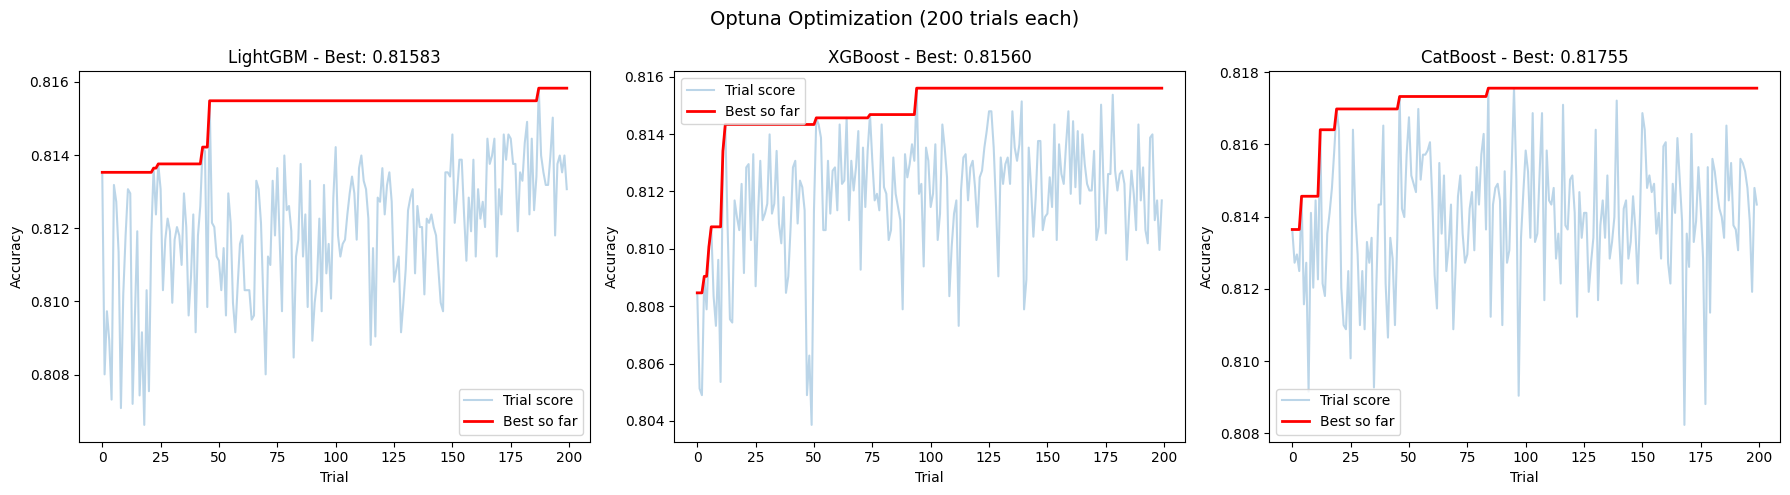

In [8]:
print('='*60)
print('OPTUNA OPTIMIZATION SUMMARY')
print('='*60)
print(f'LightGBM best 5-fold CV: {lgb_study.best_value:.5f}')
print(f'XGBoost  best 5-fold CV: {xgb_study.best_value:.5f}')
print(f'CatBoost best 5-fold CV: {cb_study.best_value:.5f}')
print(f'\nV2 baseline 10-fold CV:  0.81410 (simple avg ensemble)')

# Optimization history plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, study, name in zip(axes, [lgb_study, xgb_study, cb_study], ['LightGBM', 'XGBoost', 'CatBoost']):
    trials = study.trials
    values = [t.value for t in trials if t.value is not None]
    best_so_far = np.maximum.accumulate(values)
    ax.plot(values, alpha=0.3, label='Trial score')
    ax.plot(best_so_far, color='red', linewidth=2, label='Best so far')
    ax.set_title(f'{name} - Best: {study.best_value:.5f}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Accuracy')
    ax.legend()

plt.suptitle(f'Optuna Optimization ({N_TRIALS} trials each)', fontsize=14)
plt.tight_layout()
plt.show()

## Final Training with Optimized Params (10-fold CV)

In [9]:
# === LightGBM with best params ===
best_lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'n_estimators': 5000,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': SEED,
    **lgb_study.best_params
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

kf = StratifiedKFold(n_splits=N_FOLDS_FINAL, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**best_lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS_FINAL
    fi_lgb += model.feature_importances_ / N_FOLDS_FINAL
    
    fold_acc = accuracy_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS_FINAL} - Accuracy: {fold_acc:.5f}')

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'\nLightGBM OPTIMIZED 10-fold CV: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.382785
Fold 1/10 - Accuracy: 0.80230
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.359872
Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.357296
Fold 2/10 - Accuracy: 0.82989
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.355393
Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 0.353342
Fold 3/10 - Accuracy: 0.82184
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.415505
Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.413978
Fold 4/10 - Accuracy: 0.79862
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.367052
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.365362
Fold 5/10 - Accuracy: 0.81933
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.376015
Early stopping, best iteration is:
[399]	valid_0's binary_logloss: 0.373789
Fold 6/10 - Accuracy: 0.82969
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.361963
Fold 7/10 - Accuracy: 0.82163
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.371231
Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.368551
Fold 8/10 - Accuracy: 0.81243
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.386855
Fold 9/10 - Accuracy: 0.80552
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[276]	valid_0's binary_logloss: 0.396624
Fold 10/10 - Accuracy: 0.79977

LightGBM OPTIMIZED 10-fold CV: 0.81410


In [10]:
# === XGBoost with best params ===
best_xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'tree_method': 'hist',
    'random_state': SEED,
    'verbosity': 0,
    **xgb_study.best_params
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = xgb.XGBClassifier(**best_xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=500)
    
    oof_xgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS_FINAL
    
    fold_acc = accuracy_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS_FINAL} - Accuracy: {fold_acc:.5f}')

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'\nXGBoost OPTIMIZED 10-fold CV: {xgb_acc:.5f}')

[0]	validation_0-logloss:0.67895


[413]	validation_0-logloss:0.38564


Fold 1/10 - Accuracy: 0.80460
[0]	validation_0-logloss:0.67828


[432]	validation_0-logloss:0.36125


Fold 2/10 - Accuracy: 0.82529
[0]	validation_0-logloss:0.67841


[500]	validation_0-logloss:0.35716


[771]	validation_0-logloss:0.35795


Fold 3/10 - Accuracy: 0.82184
[0]	validation_0-logloss:0.68010


[500]	validation_0-logloss:0.41684


[862]	validation_0-logloss:0.41702


Fold 4/10 - Accuracy: 0.79287
[0]	validation_0-logloss:0.67841


[442]	validation_0-logloss:0.36385


Fold 5/10 - Accuracy: 0.82969
[0]	validation_0-logloss:0.67930


[465]	validation_0-logloss:0.37560


Fold 6/10 - Accuracy: 0.82509
[0]	validation_0-logloss:0.67815


[500]	validation_0-logloss:0.36293


[558]	validation_0-logloss:0.36275


Fold 7/10 - Accuracy: 0.81933
[0]	validation_0-logloss:0.67870


[455]	validation_0-logloss:0.36774


Fold 8/10 - Accuracy: 0.81013
[0]	validation_0-logloss:0.67906


[482]	validation_0-logloss:0.38765


Fold 9/10 - Accuracy: 0.81473
[0]	validation_0-logloss:0.67887


[460]	validation_0-logloss:0.40038


Fold 10/10 - Accuracy: 0.79977

XGBoost OPTIMIZED 10-fold CV: 0.81433


In [11]:
# === CatBoost with best params ===
best_cb_params = {
    'iterations': 5000,
    'random_seed': SEED,
    'verbose': 500,
    'early_stopping_rounds': 200,
    'task_type': 'CPU',
    **cb_study.best_params
}

oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = CatBoostClassifier(**best_cb_params)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS_FINAL
    
    fold_acc = accuracy_score(y_val, (oof_cb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS_FINAL} - Accuracy: {fold_acc:.5f}')

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'\nCatBoost OPTIMIZED 10-fold CV: {cb_acc:.5f}')

0:	learn: 0.6705032	test: 0.6706210	best: 0.6706210 (0)	total: 3.61ms	remaining: 18.1s


500:	learn: 0.2403174	test: 0.3906815	best: 0.3886553 (425)	total: 1.45s	remaining: 13s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3886552678
bestIteration = 425

Shrink model to first 426 iterations.
Fold 1/10 - Accuracy: 0.80460
0:	learn: 0.6708447	test: 0.6702222	best: 0.6702222 (0)	total: 2.55ms	remaining: 12.7s


500:	learn: 0.2386653	test: 0.3568111	best: 0.3555361 (474)	total: 1.45s	remaining: 13s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3555360814
bestIteration = 474

Shrink model to first 475 iterations.
Fold 2/10 - Accuracy: 0.83448
0:	learn: 0.6712118	test: 0.6686364	best: 0.6686364 (0)	total: 3.2ms	remaining: 16s


500:	learn: 0.2418789	test: 0.3574062	best: 0.3551696 (441)	total: 1.44s	remaining: 12.9s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3551696194
bestIteration = 441

Shrink model to first 442 iterations.
Fold 3/10 - Accuracy: 0.82759
0:	learn: 0.6701681	test: 0.6714739	best: 0.6714739 (0)	total: 2.71ms	remaining: 13.5s


500:	learn: 0.2375815	test: 0.4211969	best: 0.4190893 (412)	total: 1.46s	remaining: 13.1s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4190892961
bestIteration = 412

Shrink model to first 413 iterations.
Fold 4/10 - Accuracy: 0.79977
0:	learn: 0.6709839	test: 0.6708543	best: 0.6708543 (0)	total: 2.98ms	remaining: 14.9s


500:	learn: 0.2421052	test: 0.3714273	best: 0.3646698 (370)	total: 1.46s	remaining: 13.1s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3646698263
bestIteration = 370

Shrink model to first 371 iterations.
Fold 5/10 - Accuracy: 0.82278
0:	learn: 0.6704902	test: 0.6717669	best: 0.6717669 (0)	total: 2.63ms	remaining: 13.2s


500:	learn: 0.2404059	test: 0.3920578	best: 0.3894473 (391)	total: 1.44s	remaining: 12.9s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3894472647
bestIteration = 391

Shrink model to first 392 iterations.
Fold 6/10 - Accuracy: 0.81473
0:	learn: 0.6706567	test: 0.6701935	best: 0.6701935 (0)	total: 6.4ms	remaining: 32s


500:	learn: 0.2422377	test: 0.3594972	best: 0.3575364 (415)	total: 1.45s	remaining: 13s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3575364273
bestIteration = 415

Shrink model to first 416 iterations.
Fold 7/10 - Accuracy: 0.83659
0:	learn: 0.6707431	test: 0.6699223	best: 0.6699223 (0)	total: 2.72ms	remaining: 13.6s


500:	learn: 0.2415722	test: 0.3708449	best: 0.3681752 (394)	total: 1.44s	remaining: 13s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3681752195
bestIteration = 394

Shrink model to first 395 iterations.
Fold 8/10 - Accuracy: 0.81358
0:	learn: 0.6704809	test: 0.6712658	best: 0.6712658 (0)	total: 2.92ms	remaining: 14.6s


500:	learn: 0.2405613	test: 0.4027386	best: 0.3929295 (312)	total: 1.44s	remaining: 13s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3929294969
bestIteration = 312

Shrink model to first 313 iterations.
Fold 9/10 - Accuracy: 0.80552
0:	learn: 0.6700529	test: 0.6726257	best: 0.6726257 (0)	total: 3.38ms	remaining: 16.9s


500:	learn: 0.2407917	test: 0.4063994	best: 0.4041143 (424)	total: 1.49s	remaining: 13.4s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.404114274
bestIteration = 424

Shrink model to first 425 iterations.
Fold 10/10 - Accuracy: 0.80207

CatBoost OPTIMIZED 10-fold CV: 0.81617


## Ensemble & Submission

In [12]:
print('=== V6 OPTIMIZED Results ===')
print(f'LightGBM: {lgb_acc:.5f}')
print(f'XGBoost:  {xgb_acc:.5f}')
print(f'CatBoost: {cb_acc:.5f}')

# Simple average
oof_avg = (oof_lgb + oof_xgb + oof_cb) / 3
avg_acc = accuracy_score(y, (oof_avg > 0.5).astype(int))
print(f'\nSimple Average: {avg_acc:.5f}')

# Majority voting
votes = ((oof_lgb > 0.5).astype(int) + (oof_xgb > 0.5).astype(int) + (oof_cb > 0.5).astype(int))
vote_acc = accuracy_score(y, (votes >= 2).astype(int))
print(f'Majority Voting: {vote_acc:.5f}')

# Submission
final_proba = (test_lgb + test_xgb + test_cb) / 3
final_preds = (final_proba > 0.5)

print(f'\nTest: {final_preds.sum()} True / {len(final_preds) - final_preds.sum()} False')
print(f'Ratio: {final_preds.mean():.4f}')

print(f'\n=== VERSION COMPARISON ===')
print(f'V1:  CV 0.82653 | LB 0.80196 | Gap 0.0246 | 49 feat | manual params')
print(f'V2:  CV 0.81410 | LB 0.80710 | Gap 0.0070 | 29 feat | manual params')
print(f'V3:  CV 0.81836 | LB 0.80406 | Gap 0.0143 | 56 feat | manual params')
print(f'V5:  CV 0.81767 | LB TBD     |            | 32 feat | manual params + TE')
print(f'V6:  CV {avg_acc:.5f} | LB TBD     |            | 29 feat | OPTUNA {N_TRIALS} trials')

=== V6 OPTIMIZED Results ===
LightGBM: 0.81410
XGBoost:  0.81433
CatBoost: 0.81617

Simple Average: 0.81652
Majority Voting: 0.81468

Test: 2207 True / 2070 False
Ratio: 0.5160

=== VERSION COMPARISON ===
V1:  CV 0.82653 | LB 0.80196 | Gap 0.0246 | 49 feat | manual params
V2:  CV 0.81410 | LB 0.80710 | Gap 0.0070 | 29 feat | manual params
V3:  CV 0.81836 | LB 0.80406 | Gap 0.0143 | 56 feat | manual params
V5:  CV 0.81767 | LB TBD     |            | 32 feat | manual params + TE
V6:  CV 0.81652 | LB TBD     |            | 29 feat | OPTUNA 200 trials


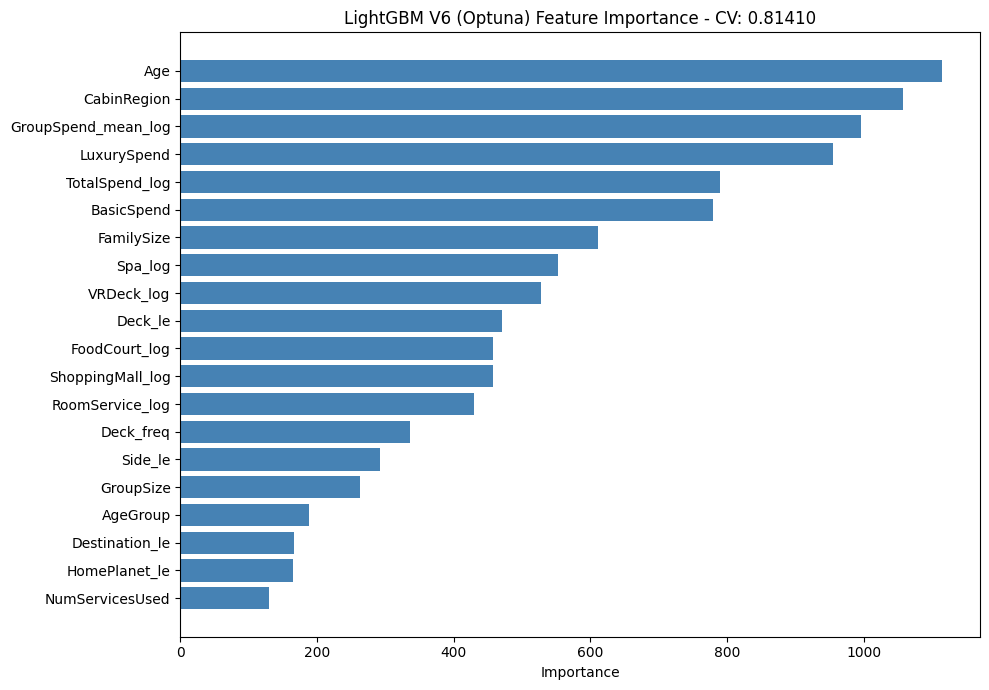

In [13]:
# Feature importance
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(20)

plt.figure(figsize=(10, 7))
plt.barh(fi_df['feature'], fi_df['importance'], color='steelblue')
plt.title(f'LightGBM V6 (Optuna) Feature Importance - CV: {lgb_acc:.5f}')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [14]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds
})
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('../submissions/submission_v6.csv', index=False)

assert submission.shape[0] == sample_sub.shape[0]
assert list(submission.columns) == list(sample_sub.columns)
assert submission['Transported'].dtype == bool

print('V6 Submission saved: submissions/submission_v6.csv')
print(submission['Transported'].value_counts(normalize=True))
submission.head()

V6 Submission saved: submissions/submission_v6.csv
Transported
True     0.516016
False    0.483984
Name: proportion, dtype: float64


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [15]:
# Save best params for future reference
print('\n' + '='*60)
print('BEST HYPERPARAMETERS (save for future use)')
print('='*60)
print(f'\n# LightGBM best params:')
for k, v in lgb_study.best_params.items():
    print(f"    '{k}': {repr(v)},")
print(f'\n# XGBoost best params:')
for k, v in xgb_study.best_params.items():
    print(f"    '{k}': {repr(v)},")
print(f'\n# CatBoost best params:')
for k, v in cb_study.best_params.items():
    print(f"    '{k}': {repr(v)},")


BEST HYPERPARAMETERS (save for future use)

# LightGBM best params:
    'num_leaves': 44,
    'max_depth': 7,
    'learning_rate': 0.030969372942932262,
    'feature_fraction': 0.6576757841672172,
    'bagging_fraction': 0.835862275982545,
    'bagging_freq': 3,
    'min_child_samples': 48,
    'reg_alpha': 1.196564578792742,
    'reg_lambda': 0.46422611416669396,
    'min_split_gain': 0.1325484921651904,

# XGBoost best params:
    'max_depth': 8,
    'learning_rate': 0.03142745431117881,
    'subsample': 0.7765649767697068,
    'colsample_bytree': 0.6993827867384605,
    'min_child_weight': 8,
    'reg_alpha': 0.018176575713448703,
    'reg_lambda': 0.0015265472174367683,
    'gamma': 1.722059975175557,
    'max_delta_step': 3,

# CatBoost best params:
    'learning_rate': 0.03873109015756435,
    'depth': 7,
    'l2_leaf_reg': 0.21548007012285542,
    'subsample': 0.9396092698948957,
    'colsample_bylevel': 0.5062767287275375,
    'min_data_in_leaf': 16,
    'random_strength': 3.2